# Importing libraries

In [1]:
!pip install scikit-learn
import sys
import pandas as pd
import numpy as np
import os
import shutil
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print(f'Python version: {sys.version}')
print(f'TensorFlow version: {tf.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 24.4 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


2023-02-08 03:38:59.955589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 03:39:07.878347: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 03:39:07.878378: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-08 03:39:09.992689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Python version: 3.8.16 (default, Jan 24 2023, 00:12:41) 
[GCC 10.2.1 20210110]
TensorFlow version: 2.11.0


# Configuring the TPU

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on CPU or GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = STRATEGY.num_replicas_in_sync
print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')

Running on CPU or GPU
N_REPLICAS: 1, IS_TPU: False


 # Loading dataset

In [3]:
path='/kaggle/input/rsna-breast-cancer-detection/'
train_data=pd.read_csv(path+'train.csv')
test_data=pd.read_csv(path+'test.csv')
path_train_images = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512'

In [4]:
# Load the csv file into a pandas dataframe
df = pd.read_csv(path+'train.csv')
print('Imbalanced dataset')
print('Number of images without cancer: ', len(df[df['cancer'] == 0]))
print('Number of images with cancer: ', len(df[df['cancer'] == 1]))
print(f'Total images: {len(df)}')

#reduce the number of samples with df['cancer'] == 0 from 53548 to some lesser number
df = df[df['cancer'] == 0].sample(4632, random_state=42).append(df[df['cancer'] == 1])
print('\nBalanced dataset')
print('Number of images without cancer: ', len(df[df['cancer'] == 0]))
print('Number of images with cancer: ', len(df[df['cancer'] == 1]))
print(f'Total images: {len(df)}')

# strip all other columns that are not needed
df = df[['patient_id', 'image_id', 'cancer']]

# Convert the data type of the columns to string
#df['image_id'] = df['image_id'].astype(str)
#df['cancer'] = df['cancer'].astype(str)
#df['patient_id'] = df['patient_id'].astype(str)
df["path"] = path_train_images + '/' + df["patient_id"].map(str) + "/" + df["image_id"].map(str) + '.png'
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Imbalanced dataset
Number of images without cancer:  53548
Number of images with cancer:  1158
Total images: 54706

Balanced dataset
Number of images without cancer:  4632
Number of images with cancer:  1158
Total images: 5790


/tmp/ipykernel_13/2468070878.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df[df['cancer'] == 0].sample(4632, random_state=42).append(df[df['cancer'] == 1])


In [5]:
#create a dataset from the dataframe using tf.data.Dataset API
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_df['cancer'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'].values, val_df['cancer'].values))

# Define some parameters
BATCH_SIZE = 16 * N_REPLICAS
IMAGE_SIZE = [512, 512, 3]
EPOCHS = 10
AUTO = tf.data.experimental.AUTOTUNE


# Function to read the image and resize it
def read_image(image_path:str, label:int):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE[:2])
    return image, label

# Function to augment the images
def augment(image, label:int):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_saturation(image, 0.9, 1.1)
    image = tf.image.random_hue(image, 0.1)
    return image, label



2023-02-08 03:39:19.957337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-08 03:39:19.957380: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 03:39:19.957407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bb98c1c99adc): /proc/driver/nvidia/version does not exist
2023-02-08 03:39:19.957788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Function to prepare the dataset for training
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.map(read_image, num_parallel_calls=AUTO)

    ds = ds.map(augment, num_parallel_calls=AUTO)

    # `prefetch` lets the dataset fetch batches, in the background while the model
    # is training.
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTO)

    return ds

num_steps = len(train_ds) // BATCH_SIZE
num_validation_steps = len(val_ds) // BATCH_SIZE

# Prepare the training and validation datasets
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 16, 16, 1024)      7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/10
289/289 [==============================] - 633s 2s/step - loss: 0.5200 - accuracy: 0.7943 - val_loss: 0.5080 - val_accuracy: 0.7908
Epoch 2/10
289/289 [============

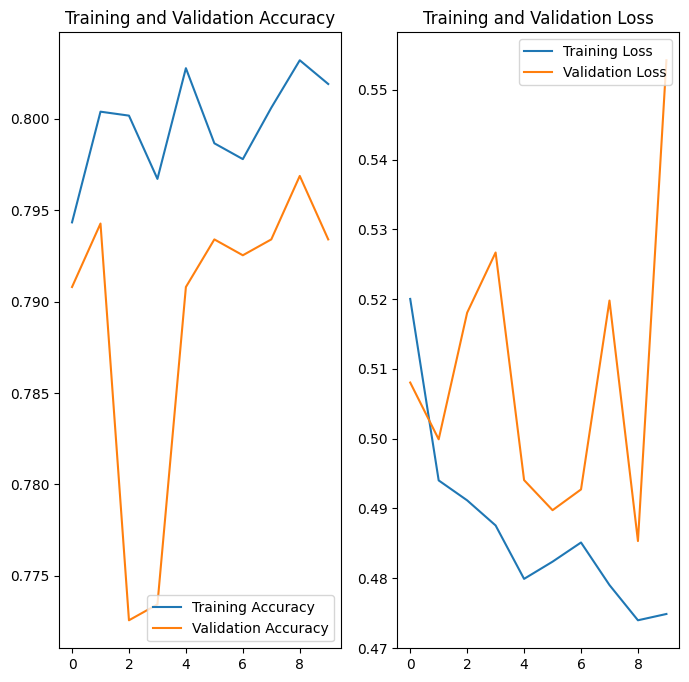

In [7]:
# Build the model using a pre-trained network (e.g. DenseNet121)
with STRATEGY.scope():
    base_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(512, 512, 3)
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    
# Train the model using fit method, not fit_generator
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=num_steps,
    validation_steps=num_validation_steps,
    epochs=EPOCHS,
    verbose=1
)

# Plot the training and validation accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()